In [10]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import librosa


# ========== 列出 npz segment 文件，方便选择 ==========
def list_segment_files(segments_root, max_show=5):
    """
    列出指定目录下所有 npz segment 文件，返回排序后的列表。
    同时打印前 max_show 个，方便你选择 index。
    """
    pattern = os.path.join(segments_root, "**", "*.npz")
    files = sorted(glob.glob(pattern, recursive=True))
    print(f"Found {len(files)} segment files.")
    for i, f in enumerate(files[:max_show]):
        print(f"[{i}] {f}")
    if len(files) > max_show:
        # print(f"... ({len(files) - max_show} more)")
        print("... (and more)")
    return files


# ========== 在指定的 Axes 上画 mel（你之前的风格） ==========
def draw_mel_on_ax(ax, y, sr, f_min=50, f_max=20000, n_mels=80, nfft=1024, hop=256, cmap="inferno"):
    """
    在给定的 matplotlib Axes 上绘制 Mel 频谱。
    """
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=n_mels,
        fmin=f_min,
        fmax=f_max,
        n_fft=nfft,
        hop_length=hop,
    )
    S_dB = librosa.power_to_db(S, ref=np.max)
    S_normalized = (S_dB + 80) / 80 * 255
    S_normalized = S_normalized.astype(np.uint8)

    img = ax.imshow(
        S_normalized,
        aspect="auto",
        origin="lower",
        extent=[0, S_dB.shape[1] * hop / sr, f_min, f_max],
        cmap=cmap,
    )
    ax.set_ylabel("Frequency (Hz)")
    ax.set_xlabel("Time (s)")
    return img


# ========== 从 npz 里画一个 segment：subplot + 双 y 轴 ==========
def plot_segment_from_npz(
    npz_path,
    f_min=0,
    f_max=2000,
    mel_n_mels=32,
    mel_nfft=1024,
    mel_hop=256,
    flow_col_name="F_SFM3300AW_24410080",
    press_col_name="P_SFM3300AW_24410080",
    flow_unit="(L/min)",
    press_unit="(cmH2O)",
):
    """
    读取一个 .npz segment 文件，绘制：
      - 上 subplot：Mel 频谱
      - 下 subplot：Flow(F) + Pressure(P)，不同颜色 & 不同 y 轴（左 Flow，右 P）

    npz 里需要字段：
      - audio, audio_rate_hz
      - audio_start_utc
      - sensor_time_epoch, sensor_values, sensor_cols
      - 可选 label
    """

    d = np.load(npz_path, allow_pickle=True)

    # ========= 1) 音频 =========
    audio = d["audio"]
    sr = int(d["audio_rate_hz"])
    if audio.dtype == np.int16:
        y = audio.astype(np.float32) / 32768.0
    else:
        y = audio.astype(np.float32)

    # ========= 2) 传感器 =========
    sensor_t = d["sensor_time_epoch"].astype(float)
    sensor_vals = d["sensor_values"].astype(float)
    cols = [str(c) for c in d["sensor_cols"]]

    # 相对时间轴：以窗口 audio_start_utc 为 0
    start_utc = float(d["audio_start_utc"])
    t_rel = sensor_t - start_utc if sensor_t.size > 0 else np.array([])

    # 找 F / P 列索引
    def get_col_idx(name):
        return cols.index(name) if name in cols else None

    idx_F = get_col_idx(flow_col_name)
    idx_P = get_col_idx(press_col_name)

    # ========= 3) 两个 subplot，高度差不多 =========
    fig, (ax_mel, ax_pq) = plt.subplots(
        2, 1,
        figsize=(12, 8),
        sharex=False,   # 两个子图 x 轴各自独立，也可以改成 True
    )

    # --- 上：Mel 频谱 ---
    draw_mel_on_ax(
        ax_mel,
        y,
        sr,
        f_min=f_min,
        f_max=f_max,
        n_mels=mel_n_mels,
        nfft=mel_nfft,
        hop=mel_hop,
        cmap="inferno",
    )
    title = os.path.basename(npz_path)
    label = d.get("label", None)
    if label is not None:
        try:
            label_str = str(label.item())
        except Exception:
            label_str = str(label)
        ax_mel.set_title(f"{title}\nlabel: {label_str}")
    else:
        ax_mel.set_title(title)

    # --- 下：Flow + Pressure，在同一 subplot 上，双 y 轴 ---
    ax_flow = ax_pq
    ax_press = ax_flow.twinx()  # 右侧 y 轴

    ln_list = []
    lb_list = []

    # Flow：左轴
    if (idx_F is not None) and (sensor_t.size > 0):
        ln1 = ax_flow.plot(
            t_rel,
            sensor_vals[:, idx_F],
            label="Flow",
            color="tab:blue",
        )
        ax_flow.set_ylabel(f"Flow {flow_unit}", color="tab:blue")
        ax_flow.tick_params(axis="y", labelcolor="tab:blue")
        # Flow 的 0 参考线
        ax_flow.axhline(0.0, color="tab:blue", linestyle="--", linewidth=0.8, alpha=0.5)

        ln_list += ln1
        lb_list += ["Flow"]

    # Pressure：右轴
    if (idx_P is not None) and (sensor_t.size > 0):
        ln2 = ax_press.plot(
            t_rel,
            sensor_vals[:, idx_P],
            label="Pressure",
            color="tab:orange",
        )
        ax_press.set_ylabel(f"Pressure {press_unit}", color="tab:orange")
        ax_press.tick_params(axis="y", labelcolor="tab:orange")
        # Pressure 的 0 参考线
        ax_press.axhline(0.0, color="tab:orange", linestyle="--", linewidth=0.8, alpha=0.5)

        ln_list += ln2
        lb_list += ["Pressure"]

    ax_flow.set_xlabel("Time in window (s)")

    if ln_list:
        ax_flow.legend(ln_list, lb_list, loc="best")

    fig.tight_layout()
    plt.show()



Found 236 segment files.
[0] ..\data\251107\2025-11-07_21-55-04-SFM3300AW_24410080.edf__record_20251107T140059Z.wav\record_20251107T140059Z.wav__2025-11-07_21-55-04-SFM3300AW_24410080.edf_win00000.npz
[1] ..\data\251107\2025-11-07_21-55-04-SFM3300AW_24410080.edf__record_20251107T140059Z.wav\record_20251107T140059Z.wav__2025-11-07_21-55-04-SFM3300AW_24410080.edf_win00001.npz
[2] ..\data\251107\2025-11-07_21-55-04-SFM3300AW_24410080.edf__record_20251107T140059Z.wav\record_20251107T140059Z.wav__2025-11-07_21-55-04-SFM3300AW_24410080.edf_win00002.npz
... (and more)


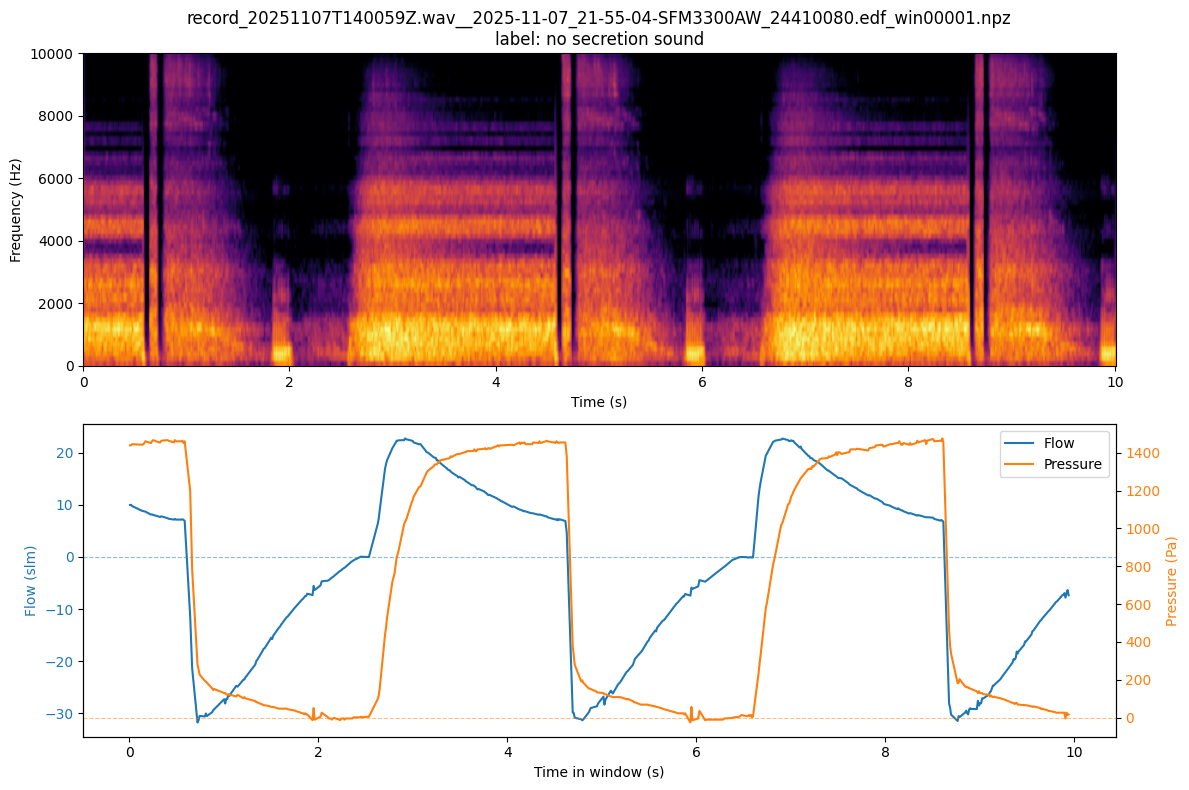

In [12]:
k = 1  # 改成你想看的编号

plt.rcParams["figure.dpi"] = 100  # 设置更高的分辨率，适合显示细节
# ========== 示例 main ==========

# 1) 你的 npz segment 所在根目录（slice_all_pairings 的 out_root）
segments_root = r"..\data\251107"

# 2) 列出前 30 个文件，看看有哪些
files = list_segment_files(segments_root, max_show=3)

# 3) 选一个 index

npz_path = files[k]

# 4) 画这个 segment：上 mel，下双轴的 p/q
plot_segment_from_npz(
    npz_path,
    f_min=0,
    f_max=10000,
    mel_n_mels=64,
    mel_nfft=1024,
    mel_hop=256,
    flow_col_name="F_SFM3300AW_24410080",
    press_col_name="P_SFM3300AW_24410080",
    flow_unit="(slm)",      # 这里可以改成你实际的单位
    press_unit="(Pa)",     # 比如 Pa / kPa / cmH2O
)
